In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import random
import os
os.environ['R_HOME'] = 'C:\Programming\R\R-4.4.2'

In [2]:
# 재현성 난수 고정
SEED = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)

In [3]:
# data load
df_name = 'freesolv'
df = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name + '.csv')

smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['CN(C)C(=O)c1ccc(cc1)OC', 'CS(=O)(=O)Cl', 'CC(C)C=C', 'CCc1cnccn1', 'CCCCCCCO']
0   -11.01
1    -4.87
2     1.83
3    -5.45
4    -4.21
Name: freesolv, dtype: float64


In [4]:
# 분자 특성 추출 class
class MolecularFeatureExtractor:
    def __init__(self):
        self.descriptors = [desc[0] for desc in Descriptors._descList]

    def extract_molecular_features(self, smiles_list):
        features_dict = {desc: [] for desc in self.descriptors}

        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                for descriptor_name in self.descriptors:
                    descriptor_function = getattr(Descriptors, descriptor_name)
                    try:
                        features_dict[descriptor_name].append(descriptor_function(mol))
                    except:
                        features_dict[descriptor_name].append(None)
            else:
                for descriptor_name in self.descriptors:
                    features_dict[descriptor_name].append(None)

        return pd.DataFrame(features_dict)

In [5]:
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,11.429183,0.002457,11.429183,0.002457,0.686360,179.219,166.115,179.094629,70,0,...,0,0,0,0,0,0,0,0,0,-11.01
1,9.397377,-3.194444,9.397377,0.925154,0.421427,114.553,111.529,113.954228,32,0,...,0,0,0,0,0,0,0,0,0,-4.87
2,3.560185,0.648148,3.560185,0.648148,0.412737,70.135,60.055,70.078250,30,0,...,0,0,0,0,0,0,0,0,0,1.83
3,4.034722,0.966111,4.034722,0.966111,0.536795,108.144,100.080,108.068748,42,0,...,0,0,0,0,0,0,0,0,0,-5.45
4,8.365587,0.364796,8.365587,0.364796,0.544191,116.204,100.076,116.120115,50,0,...,0,0,0,0,0,0,0,3,0,-4.21


# t-sne

In [6]:
df_all_features

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,11.429183,0.002457,11.429183,0.002457,0.686360,179.219,166.115,179.094629,70,0,...,0,0,0,0,0,0,0,0,0,-11.01
1,9.397377,-3.194444,9.397377,0.925154,0.421427,114.553,111.529,113.954228,32,0,...,0,0,0,0,0,0,0,0,0,-4.87
2,3.560185,0.648148,3.560185,0.648148,0.412737,70.135,60.055,70.078250,30,0,...,0,0,0,0,0,0,0,0,0,1.83
3,4.034722,0.966111,4.034722,0.966111,0.536795,108.144,100.080,108.068748,42,0,...,0,0,0,0,0,0,0,0,0,-5.45
4,8.365587,0.364796,8.365587,0.364796,0.544191,116.204,100.076,116.120115,50,0,...,0,0,0,0,0,0,0,3,0,-4.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,10.622272,-0.081946,10.622272,0.081946,0.438315,158.241,140.097,158.130680,66,0,...,0,0,0,0,0,0,0,3,0,-2.04
638,3.222222,1.250000,3.222222,1.250000,0.434794,71.123,62.051,71.073499,30,0,...,0,0,0,0,0,0,0,0,0,-5.48
639,10.036149,0.181111,10.036149,0.181111,0.568137,122.123,116.075,122.036779,46,0,...,0,0,0,0,0,0,0,0,0,-8.83
640,5.480456,0.837018,5.480456,0.837018,0.400312,134.650,119.530,134.086228,50,0,...,0,0,0,0,0,0,0,3,0,0.29


In [7]:
from sklearn.manifold import TSNE

In [ ]:
X = np.array(df_all_features)

tsne = TSNE(n_components = 2, random_state = SEED)
X_tsne = tsne.fit_transform(X)

In [20]:
X_tsne.shape

(642, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


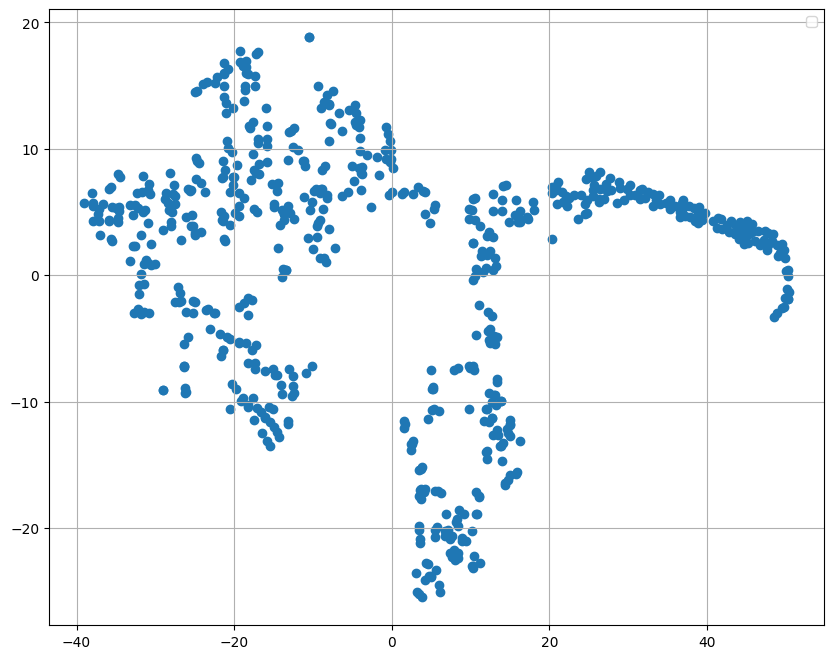

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.legend()

plt.grid(True)
plt.show()


In [23]:
X = np.array(df_all_features)

tsne = TSNE(n_components = 3, random_state = SEED)
X_tsne = tsne.fit_transform(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


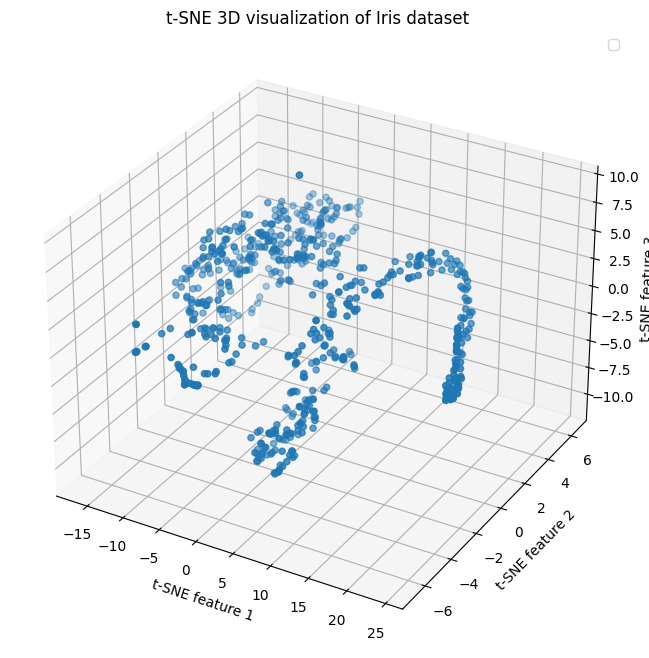

In [26]:
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2])
ax.set_title('t-SNE 3D visualization of Iris dataset')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
ax.legend()
plt.show()

In [42]:
Q1 = np.percentile(target, 25)
Q2 = np.percentile(target, 50)
Q3 = np.percentile(target, 75)

print(Q1, Q2, Q3)

-5.7275 -3.5300000000000002 -1.2149999999999999


In [47]:
target_Q1 = np.array(target[target < Q1])
target_Q2 = np.array(target[(target >= Q1) & (target < Q2)])
target_Q3 = np.array(target[(target >= Q2) & (target < Q3)])
target_Q4 = np.array(target[target >= Q3])

In [51]:
idx_Q1 = np.where(target < Q1)[0]
idx_Q2 = np.where((target >= Q1) & (target < Q2))[0]
idx_Q3 = np.where((target >= Q2) & (target < Q3))[0]
idx_Q4 = np.where(target >= Q3)[0]

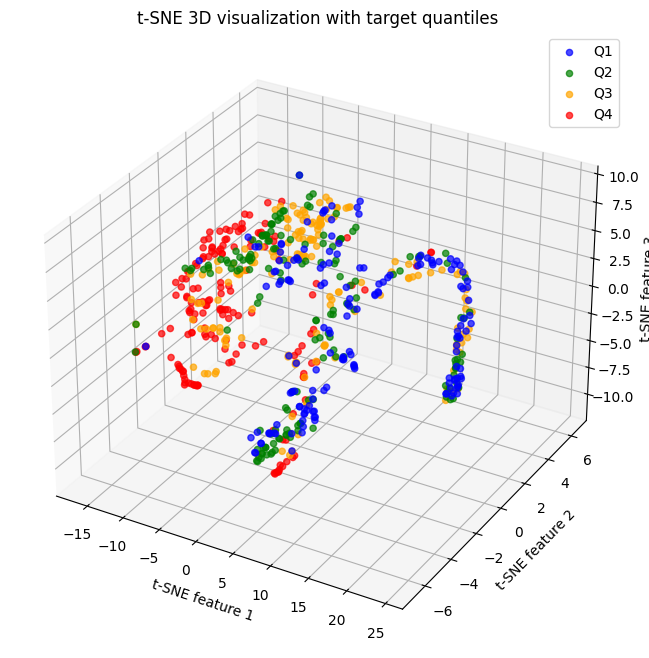

In [55]:
X = np.array(df_all_features)

tsne = TSNE(n_components = 3, random_state = SEED)
X_tsne = tsne.fit_transform(X)

# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 각 구간에 대해 다른 색으로 plot
ax.scatter(X_tsne[idx_Q1, 0], X_tsne[idx_Q1, 1], X_tsne[idx_Q1, 2], label='Q1', c='blue', alpha=0.7)
ax.scatter(X_tsne[idx_Q2, 0], X_tsne[idx_Q2, 1], X_tsne[idx_Q2, 2], label='Q2', c='green', alpha=0.7)
ax.scatter(X_tsne[idx_Q3, 0], X_tsne[idx_Q3, 1], X_tsne[idx_Q3, 2], label='Q3', c='orange', alpha=0.7)
ax.scatter(X_tsne[idx_Q4, 0], X_tsne[idx_Q4, 1], X_tsne[idx_Q4, 2], label='Q4', c='red', alpha=0.7)

ax.set_title('t-SNE 3D visualization with target quantiles')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
ax.legend()
plt.show()

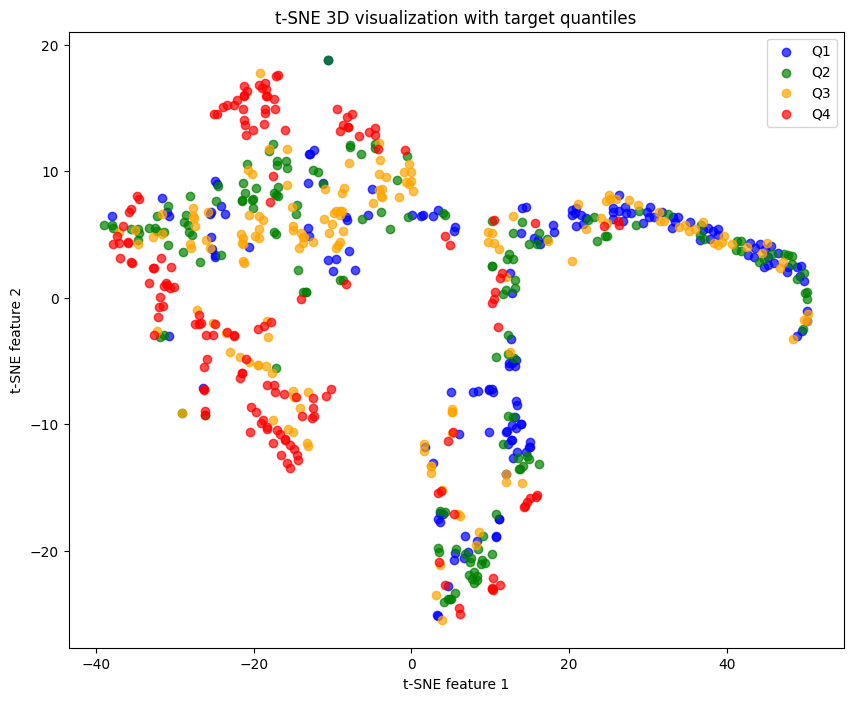

In [58]:
X = np.array(df_all_features)

tsne = TSNE(n_components = 2, random_state = SEED)
X_tsne = tsne.fit_transform(X)

# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# 각 구간에 대해 다른 색으로 plot
ax.scatter(X_tsne[idx_Q1, 0], X_tsne[idx_Q1, 1], label='Q1', c='blue', alpha=0.7)
ax.scatter(X_tsne[idx_Q2, 0], X_tsne[idx_Q2, 1], label='Q2', c='green', alpha=0.7)
ax.scatter(X_tsne[idx_Q3, 0], X_tsne[idx_Q3, 1], label='Q3', c='orange', alpha=0.7)
ax.scatter(X_tsne[idx_Q4, 0], X_tsne[idx_Q4, 1], label='Q4', c='red', alpha=0.7)

ax.set_title('t-SNE 3D visualization with target quantiles')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.legend()
plt.show()